# Le déplacement de la niche climatique de l’érable au Canada

Par __Isabelle Bouchard__, analyste de données, et __Daniel Blanchette__ Pelletier, journaliste

L'avenir de l'or ambré de l'est du Canada est-il menacé par les changements climatiques? 

D'ici la fin du siècle, la zone propice à la croissance de l'érable se déplacerait vers le nord, laissant certaines régions du sud du pays, où sont concentrées les érablières, dans de nouvelles conditions climatiques auxquelles l’acériculture pourrait difficilement s’adapter.

L’objectif de notre analyse était de mesurer à quel point les régions actuelles de production du sirop d’érable se retrouveraient d’ici 2100 à l’extérieur de la niche climatique de l’espèce à cause du réchauffement climatique.

Pour ce faire, nous avons croisé les données disponibles sur le déplacement de la niche climatique aux données du Recensement de l'agriculture (2021) de Statistique Canada. 

## Questions de recherche 

1. Où se situent les zones propices au développement de l’érable au Canada et comment seront-elles affectées par le réchauffement climatique?

2. Où se concentre la production de sirop d’érable au Canada. Et comment a-t-elle évolué au fil des ans?

3. Croisement des données : quelle proportion des entailles actuelles (et quelles régions du pays) se retrouverait à l’extérieur de la niche climatique de l’érable?

## Résumé des résultats

Selon notre analyse, la majorité des érablières canadiennes et des entailles (90 %) pourraient se retrouver à l’extérieur de la niche climatique de l’érable d’ici 2100, selon le scénario de réchauffement climatique le plus pessimiste.

Les scénarios plus modérés laissent toutefois l’est du Canada en partie à l’intérieur de la niche climatique de l’érable, selon une autre de nos analyses. 

Le reportage complet sur le sujet peut être consulté ici.

### Table des matières :
1. Lecture des données
2. Création de la table de données de travail
3. Visualisation interactive des données
4. Réponses aux questions de recherche

In [1]:
import warnings
import geopandas
import rasterio
from pathlib import Path
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from ipywidgets import interact
import matplotlib as mpl
from rasterio.plot import show as show_raster
import plotly.io as pio
from rasterio.mask import mask
from shapely.geometry import Polygon
from rasterio.transform import Affine
from shapely.geometry import box
from itables import show

from utils import read_raster, reproject_raster, compute_area, zonal_stats_for_value, register_raster, zonal_stats_intersection, zonal_stats_intersection_gain

pio.renderers.default = "notebook+pdf"
plt.rcParams['figure.figsize'] = [25, 15]
pd.set_option('display.max_columns', None, 'display.max_rows', None)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


def _show(df):
    if isinstance(df, geopandas.geodataframe.GeoDataFrame):
        df = pd.DataFrame(df.drop(columns="geometry"))

    show(df)

## Définition des variables 

In [2]:
DATA_PATH = Path("data/")
CRS = "EPSG:4326"

# 1. Lecture des données 

### 1.1. Données d'exploitations acéricoles et d'entailles d'érables

Les données d'exploitations et d'entailles proviennent de Statistique Canada. On télécharge les données pour [2011, 2016](https://www150.statcan.gc.ca/t1/tbl1/fr/cv!recreate.action?pid=3210042301&selectedNodeIds=&checkedLevels=0D1,0D2,0D3,0D4,0D5,1D1&refPeriods=20110101,20160101&dimensionLayouts=layout3,layout3,layout2&vectorDisplay=false) et [2021](https://www150.statcan.gc.ca/t1/tbl1/fr/cv.action?pid=3210036201), par région agricole de recensement (RAR).

In [3]:
level = "RAR"

df_farms = pd.concat(
    [
        pd.read_csv(DATA_PATH / "fermes" / f"{level}_2021.csv", delimiter=";"), 
        pd.read_csv(DATA_PATH / "fermes" / f"{level}_2011_2016.csv", delimiter=";"), 
    ]
).drop(
    [
        "UNITÉ DE MESURE", 
        "IDENTIFICATEUR D'UNITÉ DE MESURE", 
        "FACTEUR SCALAIRE", 
        "VECTEUR", 
        "COORDONNÉES", 
        "IDENTIFICATEUR SCALAIRE", 
        "STATUS", 
        "SYMBOLE", 
        "TERMINÉ", 
        "DÉCIMALES"
    ], 
    axis=1
).reset_index()

df_farms["GÉO"] = df_farms.apply(
    lambda row: row["GÉO"].split(" [")[0], 
    axis=1
)

df_farms["DGUID"] = df_farms.apply(
    lambda row: row["DGUID"][4:], 
    axis=1
)


df_farms = df_farms.replace(
    "Nombre d'exploitations déclarantes", 
    "num_exploitations"
).replace(
    "Nombre d'entailles", 
    "num_entailles"
).replace(
    "Nombre de fermes déclarantes", 
    "num_exploitations"
).pivot(
    index=["GÉO", "DGUID"], 
    columns=["PÉRIODE DE RÉFÉRENCE", "Entailles d'érables"], 
    values="VALEUR"
)

df_farms.columns = [f"{x}_{y}" for x, y in df_farms.columns.to_flat_index()]

_show(df_farms)

On télécharge également les données par Division de Recensement (CD) ou Région Agricole de Recensement (RAR), selon la province. À noter que ces données ne sont utilisées que pour la visualisation des régions, et non pour l'analyse.

In [4]:
def read_farms_df(level, provinces):
    farms = pd.read_csv(
        DATA_PATH / "fermes" / f"{level}_2021.csv", delimiter=";"
    ).drop(
        [
            "UNITÉ DE MESURE", 
            "IDENTIFICATEUR D'UNITÉ DE MESURE", 
            "FACTEUR SCALAIRE", 
            "VECTEUR", 
            "COORDONNÉES", 
            "IDENTIFICATEUR SCALAIRE", 
            "STATUS", 
            "SYMBOLE", 
            "TERMINÉ", 
            "DÉCIMALES"
        ], 
        axis=1
    ).reset_index()

    farms["GÉO"] = farms.apply(
        lambda row: row["GÉO"].split(" [")[0], 
        axis=1
    )

    farms["DGUID"] = farms.apply(
        lambda row: row["DGUID"][4:], 
        axis=1
    )

    farms["Province"] = farms.apply(
        lambda row: row["GÉO"].split(", ")[-1], 
        axis=1
    )

    farms = farms[farms["Province"].isin(provinces)]

    farms = farms.replace(
        "Nombre d'exploitations déclarantes", 
        "num_exploitations"
    ).replace(
        "Nombre d'entailles", 
        "num_entailles"
    ).replace(
        "Nombre de fermes déclarantes", 
        "num_exploitations"
    ).pivot(
        index=["GÉO", "DGUID"], 
        columns=["PÉRIODE DE RÉFÉRENCE", "Entailles d'érables"], 
        values="VALEUR"
    )

    farms.columns = [f"{x}_{y}" for x, y in farms.columns.to_flat_index()]
    farms["level"] = level
    
    return farms


df_farms_RAR = read_farms_df(
    "RAR", 
    provinces=[
        "Québec", 
        "Terre-Neuve-et-Labrador", 
        "Manitoba", 
        "Saskatchewan",  
        "Alberta",    
        "Colombie-Britannique",
])
df_farms_CD = read_farms_df(
    "CD", 
    provinces=[
        "Ontario", 
        "Nouveau-Brunswick",
        "Nouvelle-Écosse", 
        "Île-du-Prince-Édouard", 
])

_show(df_farms_CD)

### 1.2. Fichiers des limites géographiques

On télécharge également les fichiers des [limites géographiques des régions agricoles de recensement (RAR)](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-fra.cfm?year=21) à partir du site de Statistique Canada.

In [5]:
df_boundaries = geopandas.read_file(
    DATA_PATH / "boundaries" / "lcar000b21a_e.shp"
).to_crs(
    CRS
).drop(
    ["CARUID", "CARENAME", "LANDAREA"], 
    axis=1
).rename(
    columns={"CARFNAME": "area_name"}
)

df_boundaries["DGUID"] = df_boundaries.apply(
    lambda row: row["DGUID"][4:], 
    axis=1
)

df_boundaries["total_area"] = compute_area(df_boundaries)

_show(df_boundaries)

On visualise les limites géographiques des Régions Agricoles de Recensement.

<AxesSubplot: >

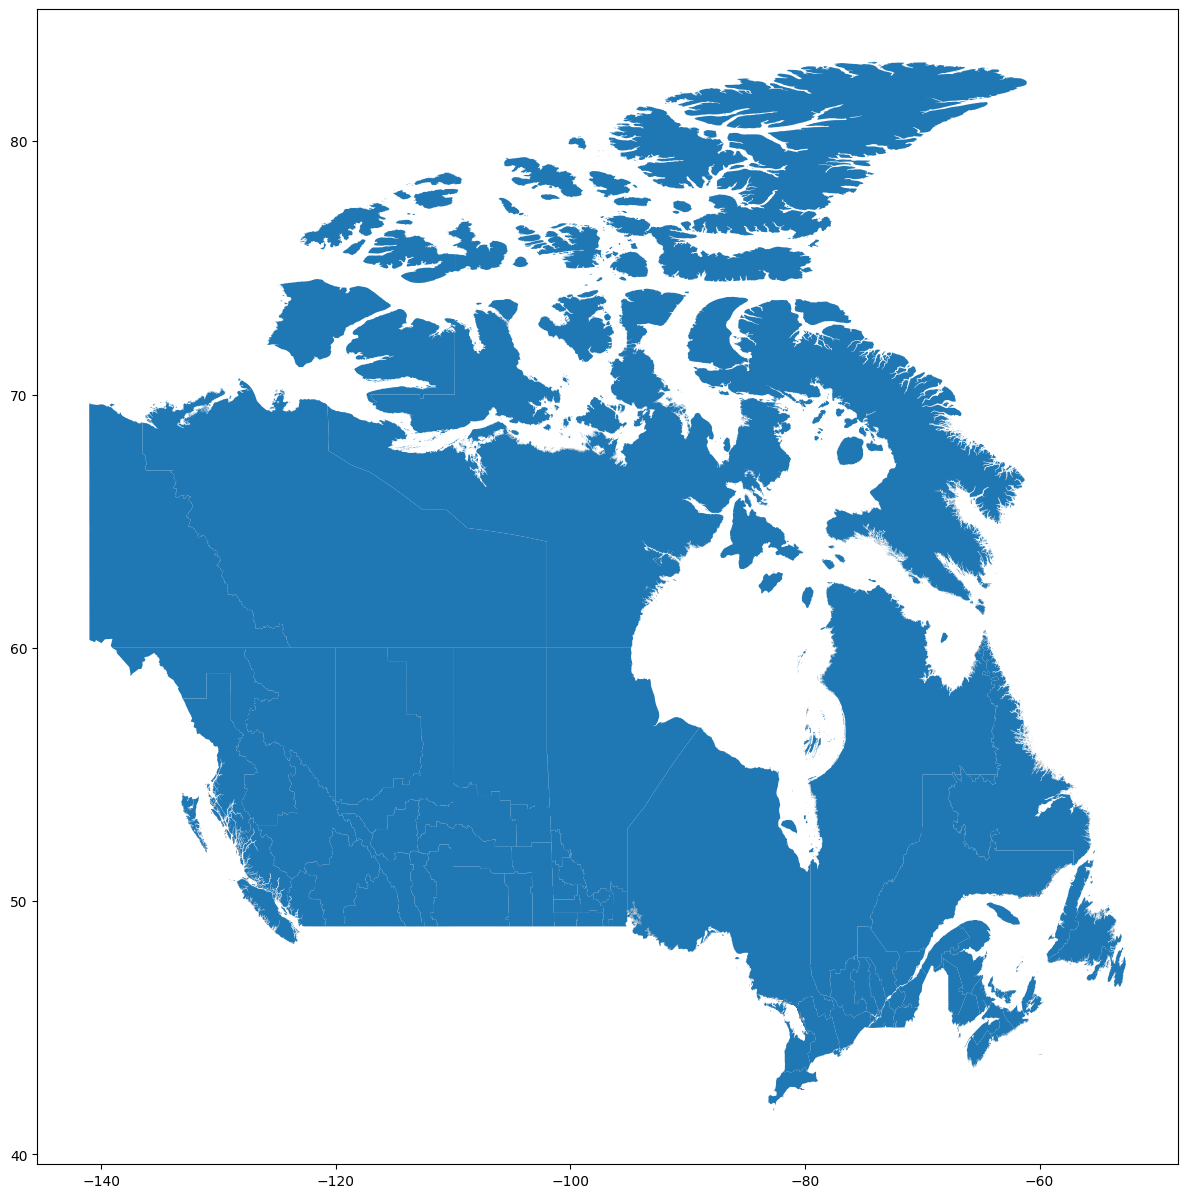

In [6]:
df_boundaries.plot()

On télécharge également les [limites géographiques des divisions de recensement (CD)](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-fra.cfm?year=21) à partir du site de Statistique Canada. Ces données ne seront utilisées que pour la visualisation et non l'analyse.

In [7]:
df_boundaries_CD = geopandas.read_file(
    DATA_PATH / "boundaries" / "ldr_000b21a_f.shp"
).to_crs(
    CRS
).drop(
    ["DRIDU", "DRGENRE", "SUPTERRE"], 
    axis=1
).rename(
    columns={
        "DRNOM": "area_name", 
        "IDUGD": "DGUID", 
        "PRIDU": "PRUID"
    }
)

df_boundaries_CD["DGUID"] = df_boundaries_CD.apply(
    lambda row: row["DGUID"][4:], 
    axis=1
)

_show(df_boundaries_CD)

On visualise les limites géographiques des Divisions de Recensement.

<AxesSubplot: >

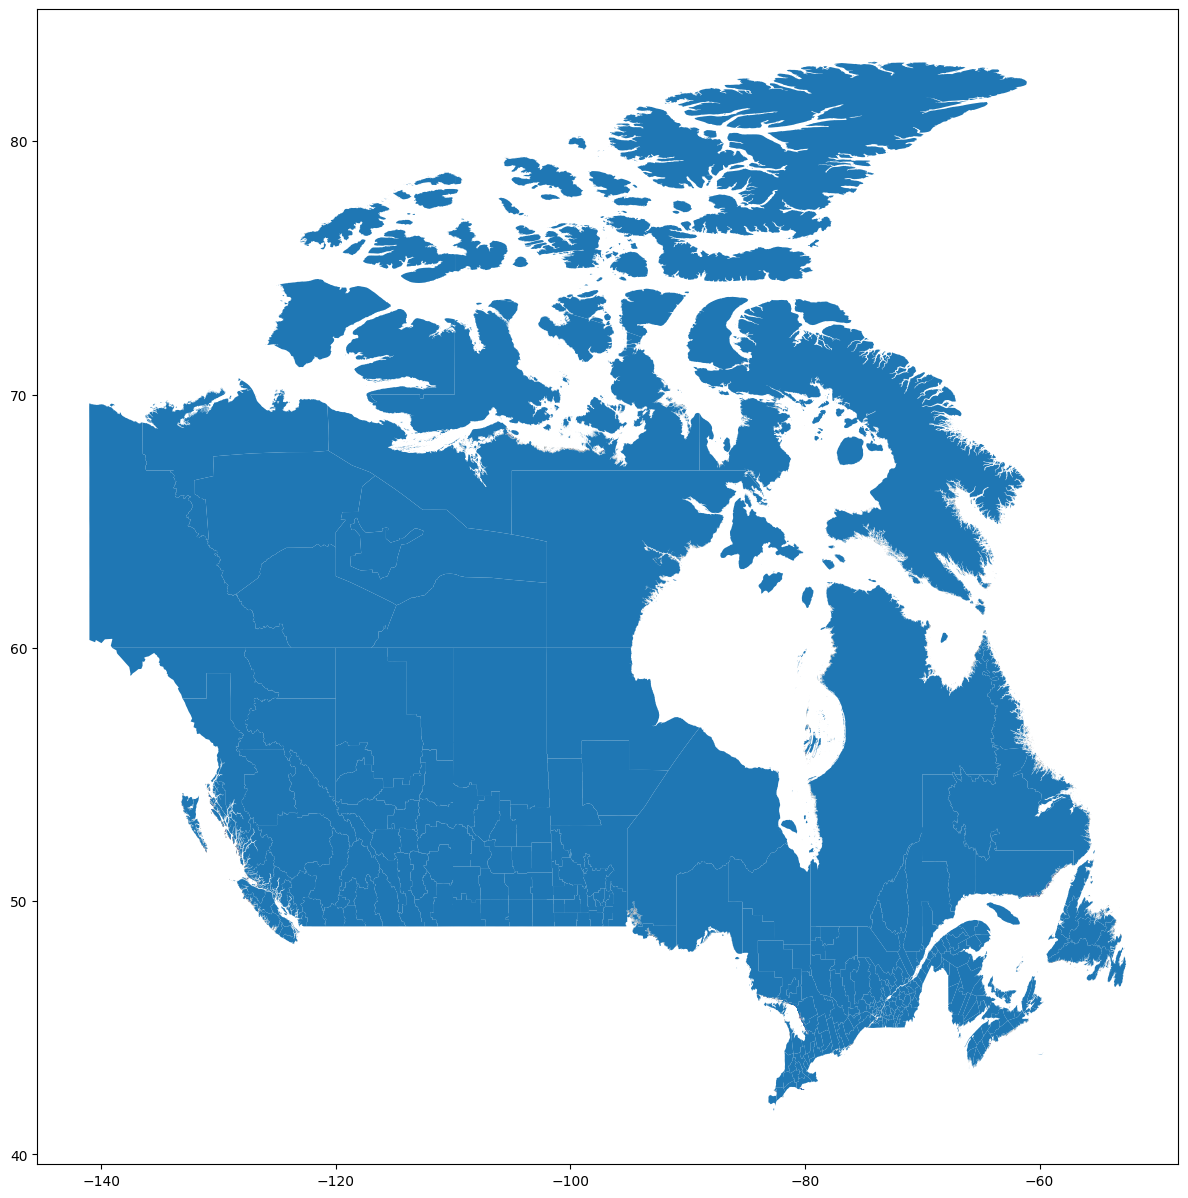

In [8]:
df_boundaries_CD.plot()

### 1.3. Projections de l'enveloppe climatique propice à l'érable

On télécharge ensuite les fichiers de projections climatiques pour l'érable à sucre et l’érable rouge (selon le scénario SDM ANUCLIM et le RCP 8.5) pour les horizons 2011-2040, 2041-2070 et 2071-2100.

On considère une enveloppe "marginale" et une enveloppe "core", selon les définitions suivantes :

- "marginale" : enveloppe climatique pour une période définie calibrée selon le min/max des conditions climatiques observées durant la période de référence.
- "core" : enveloppe climatique selon le 5e au 95e percentile des conditions climatiques observées durant la période de référence.

_Source : 
</br>
https://protect-eu.mimecast.com/s/G3lTCVNkkFqzB6DHGqvem?domain=planthardiness.gc.ca ET McKENNEY, D. W., Pedlar, J. H., Rood, R. B., & Price, D. (2011). Revisiting projected shifts in the climate envelopes of North American trees using updated general circulation models. Global Change Biology, 17(8), 2720-2730._

#### 1.3.1. Projection 2011-2040

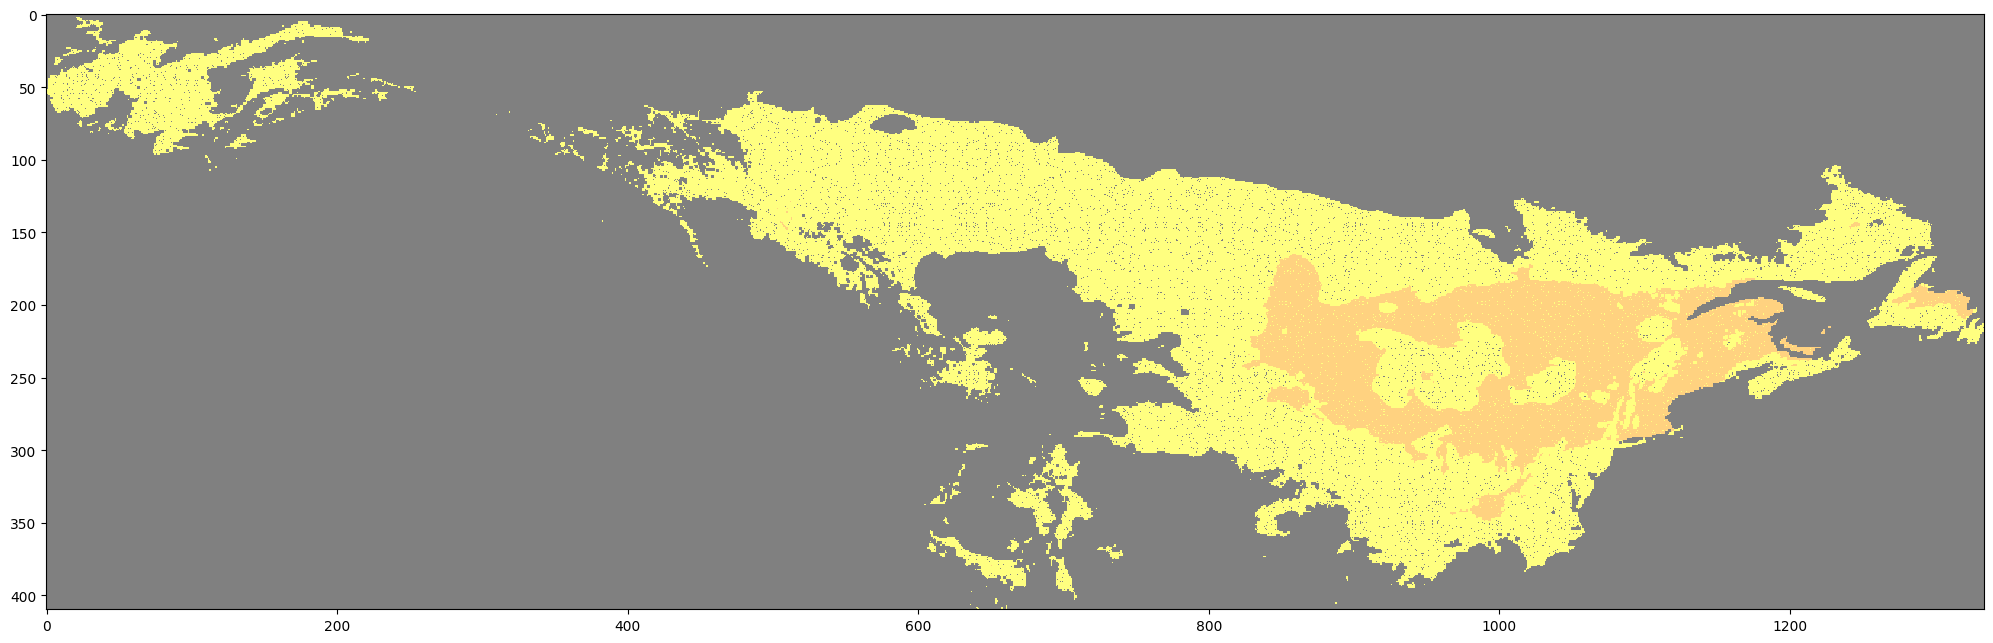

In [9]:
filename = DATA_PATH / "rasters" / "arcp8510000532011-2040.asc"

raster_2011_2040 = read_raster(filename, crs=CRS)
    
cmap = mpl.colors.ListedColormap(['black', 'yellow', 'orange'])
bounds = [raster_2011_2040.nodata, 1, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

raster_2011_2040_data = raster_2011_2040.read(1)
plt.imshow(raster_2011_2040_data, cmap=cmap, norm=norm, alpha=0.5)
plt.show()

#### 1.3.2. Projection 2041-2070

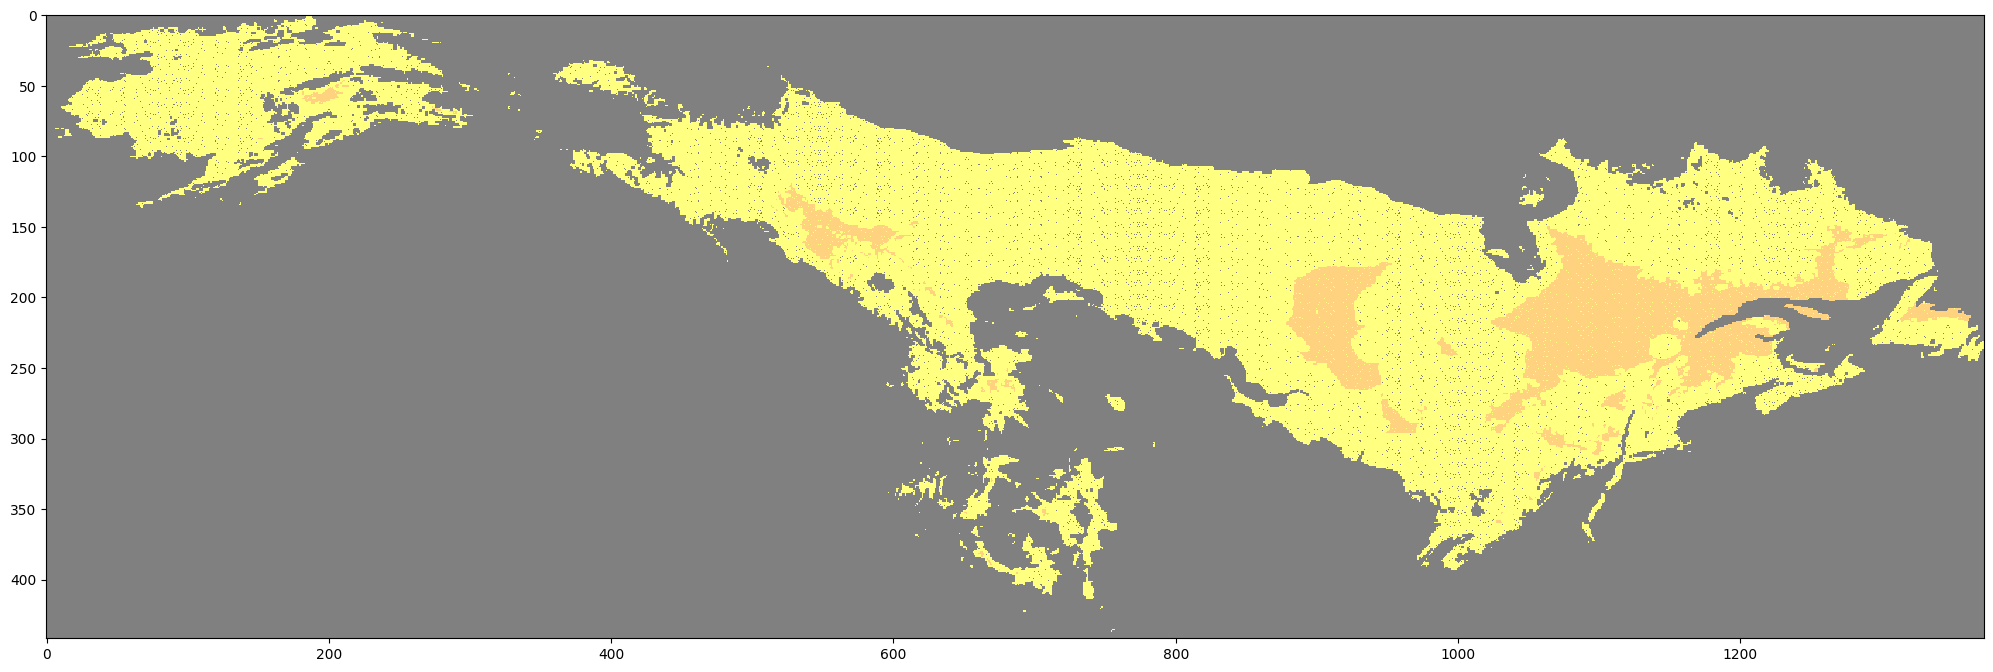

In [10]:
filename = DATA_PATH / "rasters" / "arcp8510000532041-2070.asc"

raster_2041_2070 = read_raster(filename, crs=CRS)

raster_2041_2070_data = raster_2041_2070.read(1)
plt.imshow(raster_2041_2070_data, cmap=cmap, norm=norm, alpha=0.5)
plt.show()

#### 1.3.3. Projection 2071-2100

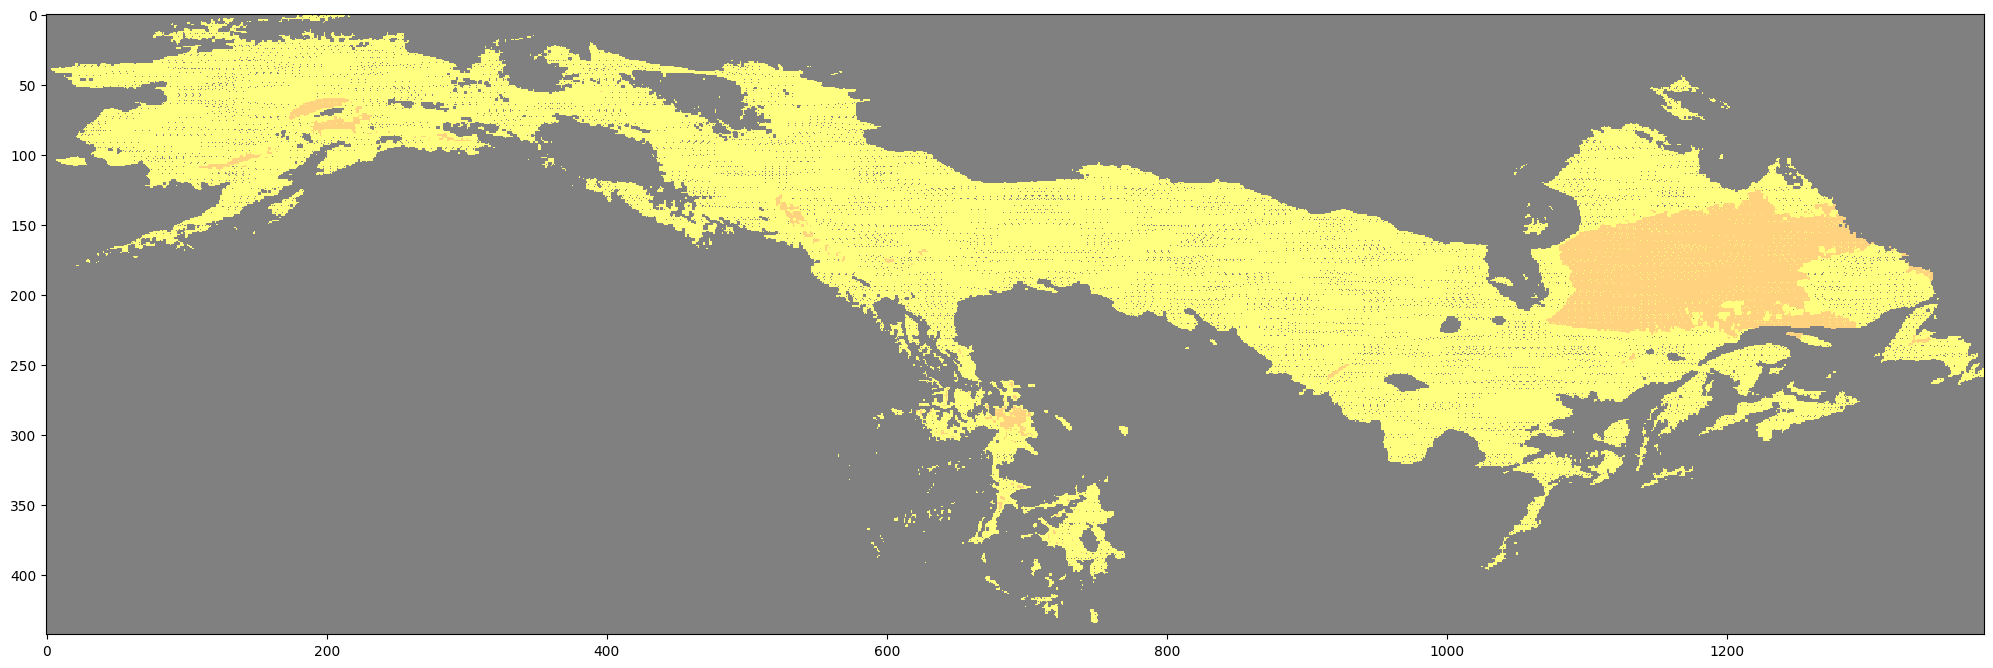

In [11]:
filename = DATA_PATH / "rasters" / "arcp8510000532071-2100.asc"
raster_2071_2100 = read_raster(filename, crs=CRS)

raster_2071_2100_data = raster_2071_2100.read(1)
plt.imshow(raster_2071_2100_data, cmap=cmap, norm=norm, alpha=0.5)
plt.show()

### 1.4. Limites de la forêt boréale

On télécharge ensuite le fichier des limites des [zones de végétation du Canada](https://open.canada.ca/data/fr/dataset/22b0166b-9db3-46b7-9baf-6584a3acc7b1). 

In [ ]:
vegetation_zones_df = geopandas.read_file(
    DATA_PATH / "vegetation" / "vegetation_zones_of_canada_2020.shp"
).to_crs(
    CRS
)

vegetation_zones_df.plot(column='niveau_1', legend=True)

### 1.5. Biomasse de l'érable

On télécharge les données de biomasse de l'érable. 

Source: 
</br>
[https://cdnsciencepub.com/doi/10.1139/cjfr-2013-0401](https://cdnsciencepub.com/doi/10.1139/cjfr-2013-0401)

In [ ]:
biomass_raster = read_raster(DATA_PATH / "cartography" / "ACESAC_volume_250m_final-100.tif", crs=CRS)

biomass_raster_data = biomass_raster.read(1)
biomass_raster_data[biomass_raster_data < 0] = -1
biomass_raster_data[biomass_raster_data > 20] = 20
plt.imshow(biomass_raster_data)
plt.show()

### 1.6. Aires colonisées par l'érable

On télécharge également les fichiers des [aires colonisées par l'érable](https://doi.org/10.1111/ddi.13630).

In [ ]:
colonized_areas_raster = read_raster(DATA_PATH / "colonized" / "ACESAC_250_iniDist.tiff", crs=CRS)

colonized_areas_raster_data = colonized_areas_raster.read(1)
colonized_areas_raster_data[np.where(colonized_areas_raster_data < 0)] = 0
plt.imshow(colonized_areas_raster_data)
plt.show()

# 2. Création de la table de données de travail

## 2.1. Projections climatiques

### 2.1.1. Calcul de l'aire des enveloppes climatiques par région

Pour chacune des régions agricoles de recensement, on calcule l'aire de l'enveloppe climatique intersectant chacune des régions pour chacune des catégories ("marginale", "core" et "autres").

In [ ]:
for value, name in [
    (1, "marginal"), 
    (3, "core"), 
    (raster_2011_2040.nodata, "rest")
]:
    df_boundaries[f"{name}_2011-2040"] = zonal_stats_for_value(
        raster=raster_2011_2040, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )
    df_boundaries[f"{name}_2041-2070"] = zonal_stats_for_value(
        raster=raster_2041_2070, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )
    df_boundaries[f"{name}_2071-2100"] = zonal_stats_for_value(
        raster=raster_2071_2100, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )

### 2.1.2. Intersection des projections

Pour chacune des régions, on calcule l'aire de chacune des régions à l'intérieur de l'enveloppe climatique en 2011-2040 qui l'est encore dans la période de projection donnée (soit 2041-2070 et 2071-2100).

On recale d'abord les images à partir des limites géographiques des trois projections.

In [ ]:
resolution = raster_2011_2040.res[0]

box1 = box(*raster_2011_2040.bounds)
box2 = box(*raster_2041_2070.bounds)
box3 = box(*raster_2071_2100.bounds)

intersection = box1.intersection(box2).intersection(box3)

registered_raster_2011_2040 = register_raster(raster_2011_2040, intersection)
registered_raster_2041_2070 = register_raster(raster_2041_2070, intersection)
registered_raster_2071_2100 = register_raster(raster_2071_2100, intersection)

transform = Affine(
    resolution,
    0.0,
    intersection.bounds[0],
    0.0,
    -resolution,
    intersection.bounds[3]
)

stats, marginal_2011_and_2041_raster = zonal_stats_intersection(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    affine=transform, 
    data_values=[1, 3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"core_or_marginal_2011_and_2041"] = stats

stats, core_2011_and_2041_raster = zonal_stats_intersection(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    affine=transform, 
    data_values=[3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"core_2011_and_2041"] = stats
    
stats, marginal_2011_and_2071_raster = zonal_stats_intersection(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    affine=transform, 
    data_values=[1, 3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"core_or_marginal_2011_and_2071"] = stats

stats, core_2011_and_2071_raster = zonal_stats_intersection(
    df_boundaries['geometry'], 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    affine=transform, 
    data_values=[3], 
    nodata_value=-999, 
    resolution=2.5
)
df_boundaries[f"core_2011_and_2071"] = stats

## 2.2. Combinaison des données de pertes et de gains de territoire avec les données d'entailles et d'exploitations

On joint les données téléchargées dans un dataframe comprenant toutes les informations requises pour répondre aux questions de recherche. On calcule quelques statistiques préalables et on nettoie la table de données finale.

In [ ]:
df = pd.merge(
    df_boundaries, 
    df_farms, 
    on="DGUID"
)

pr_df = pd.DataFrame({
    "PRUID": ["10", "11", "12", "13", "24", "35", "46", "47", "48", "59", "60", "61", "62"], 
    "province": [
        "Terre-Neuve-et-Labrador", 
        "Île-du-Prince-Édouard", 
        "Nouvelle-Écosse",
        "Nouveau-Brunswick",
        "Québec",
        "Ontario",
        "Manitoba",
        "Saskatchewan",
        "Alberta",
        "Colombie-Britannique",
        "Yukon",
        "Territoires du Nord-Ouest",
        "Nunavut"
    ]
}
)

df = df.merge(
    pr_df, 
    on="PRUID"
).drop("PRUID", axis=1)

df["rank_entailles"] = df["2021_num_entailles"].rank(
    method="min", 
    na_option="bottom", 
    ascending=False
)
df["rank_exploitations"] = df["2021_num_exploitations"].rank(
    method="min", 
    na_option="bottom", 
    ascending=False
)

df = df.rename({
    "all_2011-2040": "rest_2011-2040", 
    "all_2041-2070": "rest_2041-2070", 
    "all_2071-2100": "rest_2071-2100", 
}, axis=1)

_show(df)

On crée également une table de données avec différents niveaux de délimitation des régions (CD ou RAR) selon la province. Ces données ne seront utilisées que pour la visualisation.

In [ ]:
df_CD_and_RAR = geopandas.GeoDataFrame(
    pd.concat([
        pd.merge(
            df_farms_CD,
            df_boundaries_CD,  
            on="DGUID", 
            how="left"
        ),  
        pd.merge(
            df_farms_RAR,
            df_boundaries,  
            on="DGUID", 
            how="left"
        )
    ])
)

# 3. Visualisation des données 

## 3.1. Projection des niches climatiques et des entailles

On visualise la distribution des entailles en 2021 par rapport à la carte des niches climatiques.

La niche climatique marginale est en jaune et la niche climatique core, en orange. Les cercles bleus pointent vers le centroïde de chacune des régions agricoles de recensement et la taille du cercle est proportionnelle au nombre d'entailles en 2021.


### 3.1.1. Vue d'ensemble

#### Projection 2011-2040

In [ ]:
def _plot(df, raster, markersize_factor=50000, extent=None):
    fig, ax = plt.subplots()

    ax = show_raster(
        raster, 
        extent=[
            raster.bounds[0], 
            raster.bounds[2], 
            raster.bounds[1], 
            raster.bounds[3]
        ], 
        alpha=0.5,
        cmap=cmap, 
        norm=norm,
        with_bounds=True, 
        ax=ax
    )

    df.boundary.plot(ax=ax, lw=0.15, color="black")
    df.centroid.plot(
        markersize=df['2021_num_entailles'] / markersize_factor, 
        alpha=0.5,
        color="DarkTurquoise", 
        ax=ax
    )
    
_plot(df_CD_and_RAR, raster_2011_2040)

#### Projection 2041-2070

In [ ]:
_plot(df_CD_and_RAR, raster_2041_2070)

#### Projection 2071-2100

In [ ]:
_plot(df_CD_and_RAR, raster_2071_2100)

### 3.1.2. Vue concentrée

On zoom ici sur l'Est du pays, où se concentre la production acéricole.

#### Projection 2011-2040

In [ ]:
def _plot_zoom(df, raster, markersize_factor=5000):
    xmin = -90
    xmax = -40
    ymin = 42
    ymax = 55
    
    crop_df = df.cx[xmin: xmax, ymin: ymax]
    
    xmin = min(crop_df.bounds["minx"])
    ymin = min(crop_df.bounds["miny"])
    xmax = max(crop_df.bounds["maxx"])
    ymax = max(crop_df.bounds["maxy"])
    
    fig, ax = plt.subplots()
    
    out_image, out_transform = mask(
        raster, 
        [Polygon(((xmin, ymin), (xmax, ymin) ,(xmax, ymax), (xmin, ymax),  (xmin, ymin)))], 
        crop=True
    )

    ax = show_raster(
        out_image, 
        transform=out_transform, 
        alpha=0.5,
        cmap=cmap, 
        norm=norm,
        with_bounds=True, 
        ax=ax
    )

    crop_df.boundary.plot(ax=ax, lw=0.75, color="black")
    
    centroids = crop_df.centroid
    centroids.plot(
        markersize=crop_df['2021_num_entailles'] / markersize_factor, 
        alpha=0.35,
        color="DarkTurquoise", 
        ax=ax, 
    )
    centroids.plot(
        markersize=3,
        alpha=1,
        color="DarkSlateGrey", 
        ax=ax, 
    )

    ax.set_axis_off()
    
_plot_zoom(df_CD_and_RAR, raster_2011_2040)

#### Projection 2041-2070

In [ ]:
_plot_zoom(df_CD_and_RAR, raster_2041_2070)

#### Projection 2071-2100

In [ ]:
_plot_zoom(df_CD_and_RAR, raster_2071_2100)

## 3.2. Déplacement des niches climatiques

On visualise maintenant les régions qui gagnent ou perdent les conditions favorables au développement de l'érable. On croise ces données avec les types de végétation.

### 3.2.1. Pertes de conditions favorables 

On observe en rouge les régions qui faisaient partie de la niche climatique dans la période de projection initiale (2011-2040), mais qui n'en font plus partie dans la période de projection finale.

#### Conditions cores seulement : 2011-2040 à 2041-2070

In [ ]:
def _plot_lost_terrain(df1, df2, raster1, raster2, extent, data_value, color, nodata_value=-999, markersize_factor=50000):
    new_raster = np.ones(raster1.shape) * nodata_value
    new_raster[np.where((raster1 >= data_value) & (raster2 < data_value))] = 1
    
    fig, ax = plt.subplots()

    cmap = mpl.colors.ListedColormap(['white', color])
    bounds = [nodata_value, 1, 3]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    
    ax = show_raster(
        new_raster,
        extent=extent,
        alpha=0.3,
        cmap=cmap, 
        norm=norm,
        with_bounds=True, 
        ax=ax
    )

    df1.boundary.plot(ax=ax, lw=0.15, color="black")
    df2.plot(ax=ax, column="niveau_1", alpha=0.2, legend=True)

    
def lost_to_file(filename, raster1, raster2, raster_ref, data_value):
    out_meta = raster_ref.meta.copy()

    out_meta.update({
        'driver': 'GTiff',
        'width': raster_ref.shape[1],
        'height': raster_ref.shape[0],
        'count': 1,
        'dtype': 'float64',
        'crs': raster_ref.crs, 
        'transform': raster_ref.transform,
        'nodata': 0
    })

    new_raster = np.ones(raster1.shape) * raster_ref.nodata
    new_raster[np.where((raster1 >= data_value) & (raster2 < data_value))] = 1

    with rasterio.open(fp=filename, mode='w',**out_meta) as dst:
        dst.write(new_raster.astype(np.int), 1)
        
        
lost_to_file(
    "perte_scenario_A_2011-2040_vs_2041-2070.tiff",
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    raster_2011_2040, 
    data_value=3
)
    
_plot_lost_terrain(
    df_CD_and_RAR,
    vegetation_zones_df, 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=3, 
    color="red"
)

#### Conditions cores seulement : 2011-2040 à 2071-2100

In [ ]:
lost_to_file(
    "perte_scenario_A_2011-2040_vs_2071-2100.tiff",
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    raster_2011_2040, 
    data_value=3
)

_plot_lost_terrain(
    df_CD_and_RAR,
    vegetation_zones_df, 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=3, 
    color="red"
)

#### Conditions cores et marginales : 2011-2040 vs 2041-2070

In [ ]:
lost_to_file(
    "perte_scenario_B_2011-2040_vs_2041-2070.tiff",
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    raster_2011_2040, 
    data_value=1
)

_plot_lost_terrain(
    df_CD_and_RAR,
    vegetation_zones_df, 
    registered_raster_2011_2040, 
    registered_raster_2041_2070, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=1, 
    color="red"
)

#### Conditions cores et marginales : 2011-2040 vs 2071-2100

In [ ]:
lost_to_file(
    "perte_scenario_B_2011-2040_vs_2071-2100.tiff",
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    raster_2011_2040, 
    data_value=1
)

_plot_lost_terrain(
    df_CD_and_RAR,
    vegetation_zones_df, 
    registered_raster_2011_2040, 
    registered_raster_2071_2100, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=1, 
    color="red"
)

### 3.2.2. Gains de conditions favorables 

On observe en vert les régions qui ne faisaient pas partie de la niche climatique dans la période de projection initiale (2011-2040), mais qui en font partie dans la période de projection finale.

#### Conditions cores seulement : 2011-2040 à 2041-2070

In [ ]:
lost_to_file(
    "gain_scenario_A_2011-2040_vs_2041-2070.tiff",
    registered_raster_2041_2070, 
    registered_raster_2011_2040, 
    raster_2011_2040, 
    data_value=3
)


_plot_lost_terrain(
    df_CD_and_RAR,
    vegetation_zones_df, 
    registered_raster_2041_2070, 
    registered_raster_2011_2040, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=3, 
    color="green"
)

#### Conditions cores seulement : 2011-2040 à 2071-2100

In [ ]:
lost_to_file(
    "gain_scenario_A_2011-2040_vs_2071-2100.tiff",
    registered_raster_2071_2100, 
    registered_raster_2011_2040, 
    raster_2011_2040, 
    data_value=3
)

_plot_lost_terrain(
    df_CD_and_RAR, 
    vegetation_zones_df,
    registered_raster_2071_2100, 
    registered_raster_2011_2040, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=3, 
    color="green"
)

#### Conditions cores et marginales : 2011-2040 à 2041-2070

In [ ]:
lost_to_file(
    "gain_scenario_B_2011-2040_vs_2041-2070.tiff",
    registered_raster_2041_2070, 
    registered_raster_2011_2040, 
    raster_2011_2040, 
    data_value=1
)

_plot_lost_terrain(
    df_CD_and_RAR,
    vegetation_zones_df, 
    registered_raster_2041_2070, 
    registered_raster_2011_2040, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=1, 
    color="green"
)

#### Conditions cores et marginales : 2011-2040 à 2071-2100

In [ ]:
lost_to_file(
    "gain_scenario_B_2011-2040_vs_2071-2100.tiff",
    registered_raster_2071_2100, 
    registered_raster_2011_2040, 
    raster_2011_2040, 
    data_value=1
)

_plot_lost_terrain(
    df_CD_and_RAR,
    vegetation_zones_df, 
    registered_raster_2071_2100, 
    registered_raster_2011_2040, 
    extent=[
        raster_2011_2040.bounds[0], 
        raster_2011_2040.bounds[2], 
        raster_2011_2040.bounds[1], 
        raster_2011_2040.bounds[3]
    ], 
    data_value=1, 
    color="green"
)

### 3.3. Distribution de la biomasse et enveloppe climatique.

On veut voir si la biomasse actuelle se trouve à l'intérieur des enveloppes climatiques (2011-2040).

In [ ]:
def _plot_biomass(df, raster1, raster2, markersize_factor=50000, extent=None):
    xmin = -90
    xmax = -40
    ymin = 42
    ymax = 55
    
    crop_df = df.cx[xmin: xmax, ymin: ymax]
    
    xmin = min(crop_df.bounds["minx"])
    ymin = min(crop_df.bounds["miny"])
    xmax = max(crop_df.bounds["maxx"])
    ymax = max(crop_df.bounds["maxy"])
    
    fig, ax = plt.subplots()
    
    out_image2, out_transform2 = mask(
        raster2, 
        [Polygon(((xmin, ymin), (xmax, ymin) ,(xmax, ymax), (xmin, ymax),  (xmin, ymin)))], 
        crop=True
    )
    out_image2[out_image2 < 0] = 0
    out_image2[out_image2 > 100] = 100
    
    ax = show_raster(
        out_image2, 
        transform=out_transform2, 
        alpha=1,
        with_bounds=True, 
        ax=ax, 
        cmap="Greys"
    )
    
    out_image1, out_transform1 = mask(
        raster1, 
        [Polygon(((xmin, ymin), (xmax, ymin) ,(xmax, ymax), (xmin, ymax),  (xmin, ymin)))], 
        crop=True
    )

    ax = show_raster(
        out_image1, 
        transform=out_transform1, 
        alpha=0.3,
        cmap=cmap, 
        norm=norm,
        with_bounds=True, 
        ax=ax
    )

    crop_df.boundary.plot(ax=ax, lw=0.2, color="black")

_plot_biomass(df_CD_and_RAR, raster_2011_2040, biomass_raster)

# 4. Réponses aux questions de recherche

Pour répondre aux questions de recherche, on définit deux scénarios :
- Scénario A : on ne considère que les zones avec les conditions climatiques cores.
- Scénario B : on considère les zones avec les conditions climatiques cores et marginales.

On décline également la réponse par rapport aux projections de 2041-2070, puis aux projections de 2071-2100.

On s'attend à ce que les différences les plus marquées soient observées selon le scénario A, avec les projections de 2071-2100, et les différences les moins marquées avec le scénario B et les projections de 2041-2070.

Les conclusions aux questions de recherche sont affichées <span style="color:red"> en rouge </span>.

## 4.1. Où se situent les zones propices au développement de l’érable au Canada et comment seront-elles affectées par le réchauffement climatique?

### 4.1.1. Quelles sont les régions qui connaissent les plus fortes pertes relatives de leur territoire?

On calcule ici les pertes et les gains relatifs de territoire à l'intérieur d'une niche climatique par rapport à la niche initiale (2011-2040). On ordonne les régions de la plus forte perte à la plus faible. On indique également le rang en termes d'entailles et d'exploitations. 

In [ ]:
# Perte et gain: Scénario A 
df["perte_A_2011_vs_2041"] = df["core_2011-2040"] - df["core_2011_and_2041"]
df["perte_A_2011_vs_2071"] = df["core_2011-2040"] - df["core_2011_and_2071"]
df["gain_A_2011_vs_2041"] = df["core_2041-2070"] - df["core_2011_and_2041"]
df["gain_A_2011_vs_2071"] = df["core_2071-2100"] - df["core_2011_and_2071"]

# Perte et gain: Scénario B
df["core_or_marginal_2011-2040"] = df["core_2011-2040"] + df["marginal_2011-2040"]
df["core_or_marginal_2041-2070"] = df["core_2041-2070"] + df["marginal_2041-2070"]
df["core_or_marginal_2071-2100"] = df["core_2071-2100"] + df["marginal_2071-2100"]
df["perte_B_2011_vs_2041"] = df["core_or_marginal_2011-2040"] - df["core_or_marginal_2011_and_2041"]
df["perte_B_2011_vs_2071"] = df["core_or_marginal_2011-2040"] - df["core_or_marginal_2011_and_2071"]
df["gain_B_2011_vs_2041"] = df["core_or_marginal_2041-2070"] - df["core_or_marginal_2011_and_2041"]
df["gain_B_2011_vs_2071"] = df["core_or_marginal_2071-2100"] - df["core_or_marginal_2011_and_2071"]

# Perte et gain en POURCENTAGE par rapport à la zone initiale: Scénario A 
df["perte_pourcentage_A_2011_vs_2041"] = df["perte_A_2011_vs_2041"] / df["core_2011-2040"]
df["perte_pourcentage_A_2011_vs_2071"] = df["perte_A_2011_vs_2071"] / df["core_2011-2040"]
df["gain_pourcentage_A_2011_vs_2041"] = df["gain_A_2011_vs_2041"] / df["core_2011-2040"]
df["gain_pourcentage_A_2011_vs_2071"] = df["gain_A_2011_vs_2071"] / df["core_2011-2040"]

# Perte et gain en POURCENTAGE par rapport à la zone initiale: Scénario B
df["perte_pourcentage_B_2011_vs_2041"] = df["perte_B_2011_vs_2041"] / df["core_or_marginal_2011-2040"]
df["perte_pourcentage_B_2011_vs_2071"] = df["perte_B_2011_vs_2071"] / df["core_or_marginal_2011-2040"]
df["gain_pourcentage_B_2011_vs_2041"] = df["gain_B_2011_vs_2041"] / df["core_or_marginal_2011-2040"]
df["gain_pourcentage_B_2011_vs_2071"] = df["gain_B_2011_vs_2071"] / df["core_or_marginal_2011-2040"]

#### Scénario A (2011-2040 vs 2041-2070)


<span style="color:red"> 
<br/>
Pour plusieurs régions, près de la totalité du territoire faisant partie de la niche climatique ne le sera plus dès 2041. Par contre, ces régions n'exploitent pas toutes l'érable. C'est le cas, par exemple, de l'IPE qui perd 100% de sa niche climatique favorable, mais qui se retrouve au 42e des régions en termes de nombre d'entailles. 
    
À noter la Montérégie (5e rang d'entailles), le Centre-du-Québec (4e rang) et la Région agricole de recensement 1	Nouveau-Brunswick (9e rang) qui perdent toutes plus de 34% du territoire à l'intérieur de la niche climatique favorable.
</span>

In [ ]:
_show(
    df.sort_values(
        "perte_pourcentage_A_2011_vs_2041", 
        ascending=False
    )[[
        "area_name", 
        "province", 
        "perte_pourcentage_A_2011_vs_2041",
        "perte_A_2011_vs_2041",
        "gain_pourcentage_A_2011_vs_2041",
        "gain_A_2011_vs_2041",
        "rank_entailles",
        "rank_exploitations"
    ]].reset_index()
)

#### Scénario A (2011-2040 vs 2071-2100)


<span style="color:red"> 
<br/>
En 2071, toutes les régions à l'intérieur de la niche climatique favorable perdent plus de 83% de leur territoire. 
    
Les six régions produisant le plus d'entailles perdent la totalité de leur territoire à l'intérieur de la niche climatique.
</span>

In [ ]:
_show(
    df.sort_values(
        "perte_pourcentage_A_2011_vs_2071", 
        ascending=False
    )[[
        "area_name", 
        "province", 
        "perte_pourcentage_A_2011_vs_2071",
        "perte_A_2011_vs_2071",
        "gain_pourcentage_A_2011_vs_2071",
        "gain_A_2011_vs_2071",
        "rank_entailles",
        "rank_exploitations"
    ]].reset_index()
)

#### Scénario B (2011-2040 vs 2041-2070)

<span style="color:red"> 
<br/>
Pour le scénario B, en 2041, on retrouve principalement des régions qui ne produisent pas de sirop d'érable. 
</span>


In [ ]:
_show(
    df.sort_values(
        "perte_pourcentage_B_2011_vs_2041", 
        ascending=False
    )[[
        "area_name", 
        "province", 
        "perte_pourcentage_B_2011_vs_2041",
        "perte_B_2011_vs_2041",
        "gain_pourcentage_B_2011_vs_2041",
        "gain_B_2011_vs_2041",
        "rank_entailles",
        "rank_exploitations"
    ]].reset_index()
)

#### Scénario B (2011-2040 vs 2071-2010)

<span style="color:red"> 
<br/>
En 2071, on retrouve toutefois d'importants producteurs au haut de la liste, notamment la Montérégie (5e rang entailles) et le Centre-du-Québec (4e rang) avec des pertes de plus de 87% de leur territoire propice au développement de l'érable.
</span>


In [ ]:
_show(
    df.sort_values(
        "perte_pourcentage_B_2011_vs_2071", 
        ascending=False
    )[[
        "area_name", 
        "province", 
        "perte_pourcentage_B_2011_vs_2071",
        "perte_B_2011_vs_2071",
        "gain_pourcentage_B_2011_vs_2071",
        "gain_B_2011_vs_2071",
        "rank_entailles",
        "rank_exploitations"
    ]].reset_index()
)

### 4.1.2. Quelle proportion du Canada et des provinces est actuellement favorable au développement de l’érable? Qu'elle deviendra cette proportion avec le réchauffement climatique?

#### Canada 

On calcule la proportion du Canada qui se trouve dans la niche climatique de l'érable en 2011-2040, 2041-2070 et 2071-2100, selon les scénarios A et B.

<span style="color:red"> 
On constate que la proportion du territoire canadien propice au développement de l'érable pourrait s'accroître avec le temps, qu'on se fit au scénario A ou B. En effet, l'enveloppe climatique ne rétrécirait pas, mais elle se déplacerait plutôt vers le Nord.
</span>

In [ ]:
sum_A_2011 = df['core_2011-2040'].sum() / (df['rest_2011-2040'].sum() + df['core_or_marginal_2011-2040'].sum())
sum_B_2011 = df['core_or_marginal_2011-2040'].sum() / (df['rest_2011-2040'].sum() + df['core_or_marginal_2011-2040'].sum())

sum_A_2041 = df['core_2041-2070'].sum() / (df['rest_2041-2070'].sum() + df['core_or_marginal_2041-2070'].sum())
sum_B_2041 = df['core_or_marginal_2041-2070'].sum() / (df['rest_2041-2070'].sum() + df['core_or_marginal_2041-2070'].sum())

sum_A_2071 = df['core_2071-2100'].sum() / (df['rest_2071-2100'].sum() + df['core_or_marginal_2071-2100'].sum())
sum_B_2071 = df['core_or_marginal_2071-2100'].sum() / (df['rest_2071-2100'].sum() + df['core_or_marginal_2071-2100'].sum())

print(f"Scénario A : {round(sum_A_2011, 3)} (2011), {round(sum_A_2041, 3)} (2041), {round(sum_A_2071, 3)} (2071)")
print(f"Scénario B : {round(sum_B_2011, 3)} (2011), {round(sum_B_2041, 3)} (2041), {round(sum_B_2071, 3)} (2071)")

<span style="color:red"> 
Selon le scénario A, c'est 70 % de l'aire idéale actuelle qui le serait toujours en 2041-2070, contre seulement 2 % en 2071-2100.
<br/>
Selon le scénario B, c'est 81 % de l'aire idéale et tolérable actuelle qui le serait toujours en 2041-2070, contre seulement 65 % en 2071-2100. 
</span>

In [ ]:
sum_A_2041 = df['core_2011_and_2041'].sum() / df['core_2011-2040'].sum()
sum_B_2041 = df['core_or_marginal_2011_and_2041'].sum() / df['core_or_marginal_2011-2040'].sum()

sum_A_2071 = df['core_2011_and_2071'].sum() / df['core_2011-2040'].sum()
sum_B_2071 = df['core_or_marginal_2011_and_2071'].sum() / df['core_or_marginal_2011-2040'].sum()

print(f"Scénario A : {round(sum_A_2041, 3)} (2041), {round(sum_A_2071, 3)} (2071)")
print(f"Scénario B : {round(sum_B_2041, 3)} (2041), {round(sum_B_2071, 3)} (2071)")

#### Provinces

On calcule ensuite ces mêmes proportions à l'échelle des provinces. 
- `sum_X_YYYY` représente la proportion pour l'année de départ d'une projection donnée (`YYYY`) et un scénario (`X`).

<span style="color:red"> 
On observe un recul important de la proportion de la niche climatique de l’érable dans les provinces du Nouveau-Brunswick, de l'Ontario et de l'Île-du-Prince-Édouard. En 2071-2100, l'entièreté de ces trois provinces se trouverait dans de nouvelles conditions de croissance (selon le scénario A). La proportion de zones idéales ou favorables demeure plus stable dans le temps en considérant plutôt le scénario B.

Au Québec, une plus grande portion de la province serait propice à la croissance de l’érable avec le temps, tant selon le scénario A que le scénario B. Il en va de même pour Terre-Neuve-et-Labrador, province qui est présentement exclue dans la niche climatique de l’érable.
</span>

In [ ]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["sum_A_2011"] = df_pr['core_2011-2040'] / (df_pr['rest_2011-2040'] + df_pr['core_or_marginal_2011-2040'])
df_pr["sum_B_2011"] = df_pr['core_or_marginal_2011-2040'] / (df_pr['rest_2011-2040'] + df_pr['core_or_marginal_2011-2040'])

df_pr["sum_A_2041"] = df_pr['core_2041-2070'] / (df_pr['rest_2041-2070'] + df_pr['core_or_marginal_2041-2070'])
df_pr["sum_B_2041"] = df_pr['core_or_marginal_2041-2070'] / (df_pr['rest_2041-2070'] + df_pr['core_or_marginal_2041-2070'])

df_pr["sum_A_2071"] = df_pr['core_2071-2100'] / (df_pr['rest_2071-2100'] + df_pr['core_or_marginal_2071-2100'])
df_pr["sum_B_2071"] = df_pr['core_or_marginal_2071-2100'] / (df_pr['rest_2071-2100'] + df_pr['core_or_marginal_2071-2100'])

_show(
    df_pr[[
        "sum_A_2011", 
        "sum_A_2041", 
        "sum_A_2071", 
        "sum_B_2011", 
        "sum_B_2041", 
        "sum_B_2071", 
    ]]
)

<span style="color:red"> 
Selon le scénario A, la proportion des aires avec des conditions actuellement idéales, et qui le demeureraient en 2041-2070, est de 92 % pour le Québec, contre seulement 61 % pour T.-N.-L., 52 % pour le N.-B., 50 % pour l'Ontario, 10 % pour l'Î.-P.-É. et 0 % pour la N.-É. En 2071-2100, cette proportion s'effriterait : il ne resterait que 13 % du territoire propice à Terre-Neuve-et-Labrador et à peine 3 % au Québec. Pour toutes les autres provinces, la proportion d'aires avec des conditions actuellement idéales, et qui le seraient toujours en 2071-2100, est nulle.
</span>

In [ ]:
df_pr = df.groupby(
    "province"
).sum()


df_pr["sum_A_2041"] = df_pr['core_2011_and_2041'] / df_pr['core_2011-2040']
df_pr["sum_B_2041"] = df_pr['core_or_marginal_2011_and_2041'] / df_pr['core_or_marginal_2011-2040']

df_pr["sum_A_2071"] = df_pr['core_2011_and_2071'] / df_pr['core_2011-2040']
df_pr["sum_B_2071"] = df_pr['core_or_marginal_2011_and_2071'] / df_pr['core_or_marginal_2011-2040']

_show(
    df_pr[[
        "sum_A_2041",
        "sum_A_2071", 
        "sum_B_2041", 
        "sum_B_2071", 
    ]]
)

## 4.2. Où se concentre la production de sirop d’érable au Canada. Et comment a-t-elle évolué au fil des années?

### 4.2.1. Où se concentre la production de sirop d’érable au Canada?

#### Proportions par région agricole de recensement

On affiche les données ordonnées en fonction du nombre d'entailles en 2021 (`2021_num_entailles`). On affiche également :
- le nombre d'exploitations en 2021 (`2021_num_exploitations`)
- le rang de la région agricole de recensement en fonction du nombre d'entailles (`rank_entailles`) et du nombre d'exploitations acéricoles (`rank_exploitations`).

<span style="color:red"> 
Le Québec domine l'exploitation des érables au Canada : 32 % des entailles sont dans la région de Chaudière-Appalaches, 15% en Estrie et 15% au Bas-Saint-Laurent. On retrouve également une importante production au Nouveau-Brunswick, en Ontario et, dans une moindre mesure, en Nouvelle-Écosse. 
</span>

In [ ]:
num_entailles_2021 = df["2021_num_entailles"].sum()
num_entailles_2016 = df["2016_num_entailles"].sum()
num_entailles_2011 = df["2011_num_entailles"].sum()

num_exploitations_2021 = df["2021_num_exploitations"].sum()
num_exploitations_2016 = df["2016_num_exploitations"].sum()
num_exploitations_2011 = df["2011_num_exploitations"].sum()

df["2021_percent_entailles"] = df["2021_num_entailles"] / num_entailles_2021
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

_show(
    df.sort_values(
        "2021_num_entailles", 
        ascending=False
    ).reset_index()[[
        "area_name", 
        "province", 
        "2021_num_entailles", 
        "2021_percent_entailles", 
        "2021_num_exploitations", 
        "2021_percent_exploitations", 
        "rank_entailles",
        "rank_exploitations"
    ]]
)

#### Proportions d'entailles par province 

<span style="color:red"> 
Au total, 90 % des entailles sont au Québec. Le Nouveau-Brunswick suit avec 6 % des entailles en 2021, puis l'Ontario avec 3 %.
</span>

In [ ]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["2021_percent_entailles"] = df_pr["2021_num_entailles"] / num_entailles_2021
df_pr["2016_percent_entailles"] = df_pr["2016_num_entailles"] / num_entailles_2016
df_pr["2011_percent_entailles"] = df_pr["2011_num_entailles"] / num_entailles_2011

_show(
    df_pr[[
        "2021_percent_entailles",
        "2016_percent_entailles",
        "2011_percent_entailles"
    ]]
)

#### Proportions d'exploitations par province 

<span style="color:red"> 
La proportion d'exploitations québécoises est plus faible que sa proportion d'entailles. Il y a donc un plus grand nombre moyen d'entailles par exploitation. Le Québec compte tout de même entre 68 et 75 % des exploitations du pays, suivis de l'Ontario avec entre 21 et 26 % des exploitations.
</span>

In [ ]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["2021_percent_exploitations"] = df_pr["2021_num_exploitations"] / num_exploitations_2021
df_pr["2016_percent_exploitations"] = df_pr["2016_num_exploitations"] / num_exploitations_2016
df_pr["2011_percent_exploitations"] = df_pr["2011_num_exploitations"] / num_exploitations_2011

_show(
    df_pr[[
        "2021_percent_exploitations", 
        "2016_percent_exploitations", 
        "2011_percent_exploitations", 
    ]]
)

### 4.2.2. Quelles régions ont connu la plus forte croissance au fil des ans?

On calcule ici les différences de nombre d'entailles entre 2021 et 2011 (`diff_percent_entailles`). 

<span style="color:red"> 
Si le Manitoba a connu la plus forte hausse relative, le nombre absolu d'entailles demeure extrêmement bas. Le Nouveau-Brunswick, l'Ontario et la Nouvelle-Écosse ont connu des croissances plus marquées que les régions du Québec.
</span>

In [ ]:
df["diff_num_entailles"] = (df["2021_num_entailles"] - df["2011_num_entailles"])
df["diff_percent_entailles"] = df["diff_num_entailles"] / df["2021_num_entailles"]

_show(
        df.sort_values(
        "diff_percent_entailles", 
        ascending=False
    ).reset_index()[[
        "area_name", 
        "province", 
        "diff_num_entailles",
        "diff_percent_entailles",
        "2021_num_entailles", 
        "2011_num_entailles", 
        "2021_num_exploitations",
        "2011_num_exploitations", 
        "rank_entailles",
        "rank_exploitations"
    ]]
)

## 4.3. Croiser les données sur la répartition et l'abondance de l’érable du Canada, et les projections de niche climatique d’ici 2100, avec les données sur les entailles d’érable du recensement de l’agriculture 2021.

### 4.3.1. Quelle proportion (et quelles régions) des entailles actuelles se retrouverait dans de nouvelles conditions de croissance?



#### Scénario A (2041-2070)

Ici, on suppose que les entailles se retrouvent exclusivement dans des zones de croissance idéale. On affiche les régions agricoles de recensement qui ne se retrouveraient plus dans cette zone.

<span style="color:red"> 
Le climat des régions agricoles de recensement 2 et 3 de la Nouvelle-Écosse ne serait plus idéal au développement de l'érable dès 2041-2070. Ces régions comptent près de 400 000 entailles et 86 exploitations acéricoles en 2021.
<br/>
<br/>
On dénombre également 16 exploitations avec moins de 3000 entailles dans les régions agricoles de recensement 2, 5 et 7 du Manitoba qui se retrouveraient à l’extérieur de la niche climatique de l’érable.
</span>

In [ ]:
# Scénario A (2041)
df["2041_A_is_propice"] = df["core_2011_and_2041"] > 0
is_not_propice_2041_A_df = df[df["2041_A_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

_show(
    is_not_propice_2041_A_df[[
        "area_name", 
        "province", 
        "2021_num_entailles", 
        "2021_percent_entailles", 
        "2021_num_exploitations", 
        "2021_percent_exploitations", 
        "rank_entailles",
        "rank_exploitations"
    ]]
)

#### Scénario A (2071-2100)

On affiche les régions agricoles de recensement qui se retrouverait plus dans des conditions climatiques idéales.

<span style="color:red"> 
En 2071-2100, huit des dix régions comptant le plus grand nombre d'entailles en 2021 seraient exclues des conditions de croissance idéale pour l'érable. On note Chaudière-Appalaches, l'Estrie, le Bas-Saint-Laurent, le Centre-du-Québec et la Montérégie (Québec) ainsi que les régions agricoles de recensement 1 et 4 au Nouveau-Brunswick et la région de l'Ouest de l'Ontario.
</span>

In [ ]:
# Scénario A (2071)
df["2071_A_is_propice"] = df["core_2011_and_2071"] > 0
is_not_propice_2071_A_df = df[df["2071_A_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

_show(
    is_not_propice_2071_A_df[[
        "area_name", 
        "province", 
        "2021_num_entailles", 
        "2021_percent_entailles", 
        "2021_num_exploitations", 
        "2021_percent_exploitations", 
        "rank_entailles",
        "rank_exploitations"
    ]]
)

#### Scénario B (2041-2070)

On affiche les régions agricoles de recensement qui se retrouverait plus dans des conditions climatiques idéales ou tolérables.

<span style="color:red"> 
Selon le scénario B, aucune région importante au développement des produits de l'érable ne se retrouverait totalement exclue de la niche climatique de l’érable en 2041-2070.
</span>

In [ ]:
# Scénario B (2041)
df["2041_B_is_propice"] = df["core_or_marginal_2011_and_2041"] > 0
is_not_propice_2041_B_df = df[df["2041_B_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

_show(
    is_not_propice_2041_B_df[[
        "area_name", 
        "province", 
        "2021_num_entailles", 
        "2021_percent_entailles", 
        "2021_num_exploitations", 
        "2021_percent_exploitations", 
        "rank_entailles",
        "rank_exploitations"
    ]]
)

#### Scénario B (2071-2100)

On affiche les régions agricoles de recensement qui ne se retrouvent plus dans la niche climatique.

<span style="color:red"> 
Il en va de même en 2071-2100 : aucune région importante au développement des produits de l'érable ne se trouverait totalement exclue de la zone idéale ou tolérable.
</span>

In [ ]:
# Scénario B (2071)
df["2071_B_is_propice"] = df["core_or_marginal_2011_and_2071"] > 0
is_not_propice_2071_B_df = df[df["2071_B_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

_show(
    is_not_propice_2071_B_df[[
        "area_name", 
        "province", 
        "2021_num_entailles", 
        "2021_percent_entailles", 
        "2021_num_exploitations", 
        "2021_percent_exploitations", 
        "rank_entailles",
        "rank_exploitations"
    ]]
)

#### Proportions d'entailles et d'exploitations ne se retrouvant plus dans les zones propices selon les scénarios A et B et pour les deux périodes de projection.

<span style="color:red"> 
Au total, selon le scénario A, c'est 91,2 % des entailles et 90,4 % des exploitations acéricoles qui se retrouveraient à l'extérieur de la niche climatique idéale en 2071-2100.
    
Les proportions sont minimes pour le scénario A en 2041-2070, ainsi que pour le scénario B. 
</span>

In [ ]:
ratio_entailles_A_2041 = is_not_propice_2041_A_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()
ratio_entailles_A_2071 = is_not_propice_2071_A_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()

ratio_entailles_B_2041 = is_not_propice_2041_B_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()
ratio_entailles_B_2071 = is_not_propice_2071_B_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()

ratio_exploitations_A_2041 = is_not_propice_2041_A_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()
ratio_exploitations_A_2071 = is_not_propice_2071_A_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()

ratio_exploitations_B_2041 = is_not_propice_2041_B_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()
ratio_exploitations_B_2071 = is_not_propice_2071_B_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()


print(f"Scénario A (entailles) : {round(ratio_entailles_A_2041, 3)} (2041), {round(ratio_entailles_A_2071, 3)} (2071)")
print(f"Scénario A (exploitations) : {round(ratio_exploitations_A_2041, 3)} (2041), {round(ratio_exploitations_A_2071, 3)} (2071)")
print(f"Scénario B (entailles) : {round(ratio_entailles_B_2041, 3)} (2041), {round(ratio_entailles_B_2071, 3)} (2071)")
print(f"Scénario B (exploitations) : {round(ratio_exploitations_B_2041, 3)} (2041), {round(ratio_exploitations_B_2071, 3)} (2071)")

### 4.3.2. À quel point les régions qui ont connu la plus forte croissance resteront-elles dans des zones propices au développement de l’érable ou se retrouveront-elles au contraire dans les zones où sa croissance pourrait être affectée?

On affiche les données ordonnées selon la perte d'entailles entre 2021 et 2011 (`diff_num_entailles`). 
- On indique également si les régions se retrouvent dans la zone propice (`YYYY_X_is_propice`) selon l'année de début de la projection (`YYYY`) et le scénario (`X`). 

<span style="color:red"> 
Le climat des sept régions ayant connu la plus forte croissance du nombre d'entailles de 2011 à 2021 ne serait plus idéal au développement de l'érable en 2071-2100.
</span>

In [ ]:
_show(
    df.sort_values("diff_percent_entailles", ascending=False).reset_index()[[
        "area_name",
        "province",
        "diff_num_entailles",
        "diff_percent_entailles",
        "2021_percent_entailles",
        "rank_entailles",
        "2041_A_is_propice",
        "2071_A_is_propice",
        "2041_B_is_propice",
        "2071_B_is_propice"
    ]]
)

# 4.4. Où enregistre-t-on les plus importants gains de territoire dans l'enveloppe climatique propice au développement de l'érable?

On observe ici les régions pour lesquelles il existe un potentiel de migration de l'érable. On affiche `gain_X_YYYY` où `X` représente les conditions climatiques considérées (cores ou marginales) et `YYYY` représente l'année de projection.

### Scénario A (2041-2070)

<br/>
<span style="color:red"> 
On observe d'importants gains dans des régions nordiques, notamment le Saguenay--Lac-Saint-Jean--Côte-Nord et l'Abitibi-Témiscamingue--Nord-du-Québec, où plus de 14000 km carré du territoire n'avaient pas les conditions climatiques propices au développement de l'érable 2011-2040, mais les auront en 2041-2070, pour chacune des régions. 
</span>

In [ ]:
_show(
    df.sort_values("gain_A_2011_vs_2041", ascending=False).reset_index()[[
        "area_name",
        "province",
        "gain_A_2011_vs_2041",
        "2021_percent_entailles",
        "rank_entailles",
        "total_area",
    ]]
)

### Scénario A (2071-2100)
<br/>
<span style="color:red"> 
En 2071-2100, on observe d'encore plus importants gains dans ces mêmes régions nordiques. Plus de la moitié du territoire de l'Abitibi-Témiscamingue et du Nord du Québec développerait des conditions climatiques favorables. 
    
On observe toutefois que la migration de la niche climatique favorable en 2041-2070 au Nord de l'Ontario n'est que de courte durée: lorsqu'on observe les projections de 2071-2100, la région n'enregistre que des gains négligeables (12 km carré). 
</span>

In [ ]:
_show(
    df.sort_values("gain_A_2011_vs_2071", ascending=False).reset_index()[[
        "area_name",
        "province",
        "gain_A_2011_vs_2071",
        "2021_percent_entailles",
        "rank_entailles",
        "total_area",
    ]]
)

### Scénario B (2041-2070)

<span style="color:red"> 
Selon le scénario B, l'Abitibi-Témiscamingue et le Nord du Québec enregistrent les gains les plus importants, avec près de la moitié du territoire nouvellement dans la niche climatique tolérable. 
    
On enregistre des gains plus modérés, mais dans un plus grand nombre de régions, dont les régions plus nordiques, mais également certaines régions plus au centre ou à l'Ouest du pays.
</span>

In [ ]:
_show(
    df.sort_values("gain_B_2011_vs_2041", ascending=False).reset_index()[[
        "area_name",
        "province",
        "gain_B_2011_vs_2041",
        "2021_percent_entailles",
        "rank_entailles",
        "total_area",
    ]]
)

### Scénario B (2071-2100)
<br/>
<span style="color:red"> 
Encore selon le scénario B, l'Abitibi-Témiscamingue--Nord-du-Québec conserve en bonne partie les nouvelles conditions climatiques favorables en 2071-2100.
</span>

In [ ]:
_show(
    df.sort_values("gain_B_2011_vs_2071", ascending=False).reset_index()[[
        "area_name",
        "province",
        "gain_B_2011_vs_2071",
        "2021_percent_entailles",
        "rank_entailles",
        "total_area",
    ]]
)

# 5. Autres questions

## 5.1. Proportion des entailles / exploitations dans des zones qui ne sont pas propices?

On constate que moins de 1% des entailles totales se retrouvent à l'extérieur de la niche climatique core.

In [ ]:
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

_show(
    df[
        df["core_2011-2040"] == 0
    ].sort_values(
        "2021_percent_exploitations", 
        ascending=False
    ).reset_index()[[
        "2021_percent_exploitations", 
        "area_name"
    ]]
)

On constate que moins de 1% des entailles totales se retrouvent à l'extérieur de la niche climatique marginale.

In [ ]:
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

_show(
    df[
        df["core_or_marginal_2011-2040"] == 0
    ].sort_values(
        "2021_percent_exploitations", 
        ascending=False
    ).reset_index()[[
        "2021_percent_exploitations", 
        "area_name"
    ]]
)